## Downloading Raw Data

In [2]:
# import requests
# import zipfile
# import os

# def downloadFile(url, destination):
#     fileId = url.split('/')[5]
    

#     url='https://drive.google.com/uc?export=download&id=' + fileId
    

#     response = requests.get(url)
    

#     with open(destination, "wb") as file:
#         file.write(response.content)

# fileUrl = "https://drive.google.com/file/d/1Emdky32QEjyNCAxktJV90G2hxO8NHEeI/view?usp=sharing"  
# path = "ipl_json.zip"  
# downloadFile(fileUrl,path)
# with zipfile.ZipFile(path, 'r') as zip_ref:
#         zip_ref.extractall()


# Extracting Data

In [53]:
import os
import json
import pandas as pd
import pydash

'''
@function getValueFromJson
@description Returns value from the json for the key passed
@default returns zero if key is not found
'''
def getValueFromJson(json, key, default=0): 
    return pydash.get(json, key, default)

In [54]:
path = 'ipl_json/'
filelist = os.listdir(path)

In [55]:
extract = []
playOffEvent = set()
for file in filelist:
    with open(f'{path}/{file}','r') as f:
        data = json.load(f)
        event = getValueFromJson(data,'info.event.match_number')
        team1 = getValueFromJson(data,'info.teams.0')
        team2 = getValueFromJson(data,'info.teams.1')
        outcome = getValueFromJson(data,'info.outcome.winner')
        date = getValueFromJson(data,'info.dates.0')
        season = getValueFromJson(data,'info.season')
        if outcome == 0:
            outcome = getValueFromJson(data,'info.outcome.result')
        if event == 0:
            event = getValueFromJson(data,'info.event.stage')
            playOffEvent.add(event)
        extract.append({
            'date' : date,
            'team1' : team1,
            'team2' : team2,
            'outcome' : outcome,
            'event': event,
            'season' : str(season)
        })

Creating DataFrame prepating data and creating a csv file for the extracted data

Note: Rising Pune Supergiant and Rising Pune Supergiants are assumed to be the same team

In [56]:
df = pd.DataFrame(extract)
df.season.replace(['2007/08','2009/10','2020/21'],['2008','2010','2020'],inplace=True)
df.team1.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)
df.team2.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)
df.outcome.replace('Rising Pune Supergiant','Rising Pune Supergiants',inplace=True)

# uncomment the below code to get rid of the assumption that Kings XI Punjab and Delhi Daredevils are the same teams as Punjab Kings and Delhi Capitals
df.team1.replace('Kings XI Punjab','Punjab Kings',inplace=True)
df.team2.replace('Kings XI Punjab','Punjab Kings',inplace=True)
df.outcome.replace('Kings XI Punjab','Punjab Kings',inplace=True)

df.team1.replace('Delhi Daredevils','Delhi Capitals',inplace=True)
df.team2.replace('Delhi Daredevils','Delhi Capitals',inplace=True)
df.outcome.replace('Delhi Daredevils','Delhi Capitals',inplace=True)

df.to_csv('ipl_match_results.csv',index=False)

# IPL Elo Ratings Calculator

##### Relevant Imports

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#### Reading CSV file with initial Match by Match Results and relevant Elo rating

In [58]:
df = pd.read_csv('ipl_match_results.csv')

In [59]:
df.sample(5)

,date,team1,team2,outcome,event,season
968,2015-05-09,Delhi Capitals,Sunrisers Hyderabad,Sunrisers Hyderabad,45,2015
229,2008-05-25,Kolkata Knight Riders,Punjab Kings,Kolkata Knight Riders,52,2008
231,2009-04-29,Punjab Kings,Mumbai Indians,Punjab Kings,20,2009
872,2008-04-25,Punjab Kings,Mumbai Indians,Punjab Kings,10,2008
331,2008-05-01,Deccan Chargers,Punjab Kings,Punjab Kings,19,2008


### Elo Rating Update Formula

The Elo rating is updated after each game based on the game outcome. The new rating  R'  is calculated using the formula:

$$
R' = R + K \times (S - E)
$$

Where:
-  R  is the current rating.
-  R'  is the new rating.
-  K  is the K-factor, which determines the maximum possible change in rating.
-  S  is the score of the game (1 for a win, 0.5 for a draw, and 0 for a loss).
-  E  is the expected score.

### Expected Score Formula

The expected score  E  of a player/team is calculated using the formula:

$$
E = \frac{1}{1 + 10^{(R_{\text{opponent}} - R) / 400}}
$$

Where:
-  R  is the player's/team's current rating.
-  R<sub>opponent</sub>  is the opponent's rating.

These formulas are used to calculate and update Elo ratings based on match outcomes, taking into account the relative strength of the opponents as indicated by their current ratings.


In [60]:
def expectedScore(ratingA, ratingB):
    return 1 / (1 + 10 ** ((ratingB - ratingA) / 400))

Notes in update elo rating:
- teams with a relative low elo rating (difference of > 25) are rewarded with a higher k Factor
- league matches are given low kFactor while playoff matches are given a higher K factor

In [61]:
def updateElo(ratingA, ratingB, outcome, baseKFactor):
    # Calculate the rating difference
    ratingDiff = abs(ratingA - ratingB)

    if ratingDiff > 25:  
        kFactor = baseKFactor + 10  
    else:
        kFactor = baseKFactor

    expectedA = expectedScore(ratingA, ratingB)
    expectedB = expectedScore(ratingB, ratingA)

    if outcome == 'win':
        scoreA = 1
        scoreB = 0
    elif outcome == 'tie':
        scoreA = 0.5
        scoreB = 0.5
    else:  # no_result
        # No change in ratings for no result
        return ratingA, ratingB

    newRatingA = ratingA + kFactor * (scoreA - expectedA)
    newRatingB = ratingB + kFactor * (scoreB - expectedB)

    return round(newRatingA, 3), round(newRatingB, 3)

- Iterate over each row of the dataframe and calculate the elo rating after each match
- Create a Dictionary to keep track of current elo ratings of a team and create an empty list to keep track of elo rating of team by date

In [62]:
currentElo = {team: 1000 for team in set(df['team1']).union(set(df['team2']))}
eloRatingMatch = []
matchCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}
winCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}
tieCount = {team: 0 for team in set(df['team1']).union(set(df['team2']))}
playoffMatches = ['Qualifier 2','Qualifier 1','3rd Place Play-Off','Semi Final','Eliminator','Elimination Final','Final']
for index, row in df.iterrows():
    date = row['date']
    team1 = row['team1']
    team2 = row['team2']
    winner = row['outcome']
    season = row['season']
    event = row['event']
    outcome = 'win' if row['outcome'] == team1 else 'tie' if row['outcome'] == 'tie' else 'no_result'


    matchCount[team1] += 1
    matchCount[team2] += 1

    # Update win counts
    if winner == team1:
        winCount[team1] += 1
    elif winner == team2:
        winCount[team2] += 1
    elif winner == 'tie':
        tieCount[team1] +=1
        tieCount[team2] += 1
    # Update Elo ratings
    kFactor = 30
    if event in playoffMatches:
        kFactor = 40
    newEloTeam1, newEloTeam2 = updateElo(currentElo[team1], currentElo[team2], outcome,kFactor)

    eloRatingMatch.append((matchCount[team1], team1, newEloTeam1,season))
    eloRatingMatch.append((matchCount[team2], team2, newEloTeam2,season))

    # Set new Elo ratings in the DataFrame
    df.at[index, 'eloTeam1'] = newEloTeam1
    df.at[index, 'eloTeam2'] = newEloTeam2

    # Update current Elo ratings
    currentElo[team1] = newEloTeam1
    currentElo[team2] = newEloTeam2

#### Current Elo Ratings of Each Team that has participated in IPL

In [92]:
eloData = list(currentElo.items())
eloDf = pd.DataFrame(eloData, columns=['team', 'eloRating'])
eloDf.sort_values('eloRating',ascending=False,inplace=True)
eloDf.reset_index(inplace=True,drop=True)
eloDf['totalMatches'] = eloDf['team'].map(matchCount)
eloDf['wins'] = eloDf['team'].map(winCount)
eloDf['ties'] = eloDf['team'].map(tieCount)
eloDf['winRatio'] = round(eloDf['wins'] / eloDf['totalMatches'],3) 
display(eloDf)

,team,eloRating,totalMatches,wins,ties,winRatio
0,Chennai Super Kings,1139.050,224,131,1,0.585
1,Royal Challengers Bangalore,1116.023,240,114,3,0.475
2,Gujarat Titans,1084.687,33,23,0,0.697
3,Mumbai Indians,1057.100,247,138,4,0.559
4,Punjab Kings,1044.234,232,104,4,0.448
5,Lucknow Super Giants,1017.219,30,17,0,0.567
6,Delhi Capitals,996.838,238,105,4,0.441
7,Gujarat Lions,991.245,30,13,1,0.433
8,Rising Pune Supergiants,980.733,30,15,0,0.500
9,Rajasthan Royals,976.936,206,101,3,0.490


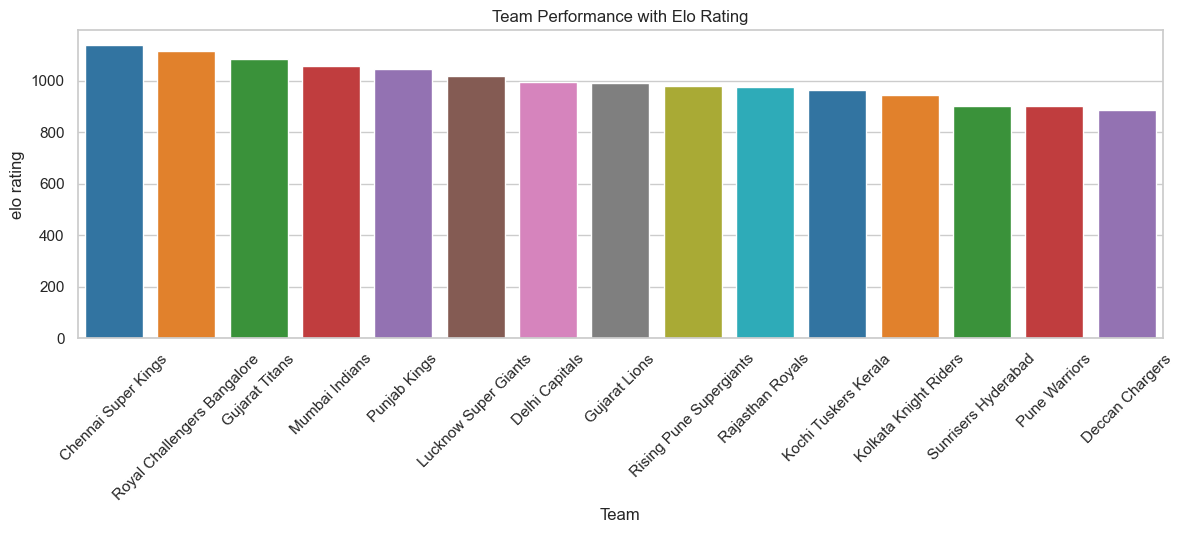

In [117]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(14,4))

sns.barplot(data=eloDf, x="team", y="eloRating", hue='team',legend=False,palette="tab10")

plt.xlabel('Team')
plt.ylabel('elo rating')
plt.title('Team Performance with Elo Rating')
plt.xticks(rotation=45)

plt.show()

In [99]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
df = pd.read_csv('iplMatchByMatchElo.csv')

In [95]:
teams = list(df.team.unique())

inactiveTeams = ['Gujarat Lions','Deccan Chargers','Kochi Tuskers Kerala','Rising Pune Supergiants','Pune Warriors']
grayCodes = ['#404040','#585858','#585858','#707070','#888888','#A0A0A0']

colorScale = zip(inactiveTeams,grayCodes)
colorScale = dict(colorScale)

color_scale = {
    'Team1': '#1f77b4', 'Team2': '#ff7f0e', 'Team3': '#2ca02c',
    'Team4': '#d62728', 'Team5': '#9467bd', 'Team6': '#8c564b',
    'Team7': '#e377c2', 'Team8': '#7f7f7f', 'Team9': '#bcbd22',
    'Team10': '#17becf', 'Team11': '#1f77b4', 'Team12': '#ff7f0e',
}


colors = list(color_scale.values())
count = 0
for team in teams:
    if team not in inactiveTeams:
        colorScale[team] = colors[count]
        count +=1

In [127]:
lineFig = px.line(df, x="matchNo", y="eloRating", color="team", 
              title="Elo Ratings of Cricket Teams Over Matches",
              labels={"matchNo": "Match Number", "rating": "Elo Rating"},
              color_discrete_map=colorScale)

lineFig.show()

In [128]:
teams = df['team'].unique()

subFig = make_subplots(rows=5, cols=3, subplot_titles=[f"{team}" for team in teams])

row = 1
col = 1


for team in teams:
    team_df = df[df['team'] == team]
    subFig.add_trace(
        go.Scatter(x=team_df['matchNo'], y=team_df['eloRating'], mode='lines', name=team),
        row=row, col=col
    )
    subFig.update_xaxes(title_text="Match Number", row=row, col=col)
    subFig.update_yaxes(title_text="Elo Rating", row=row, col=col)
    # Update row and column indices for the next subplot
    col += 1
    if col > 3:
        col = 1
        row += 1


subFig.update_layout(height=1200, width=1200, title_text="Match By Match Elo Ratings of Teams", showlegend=False)
subFig.show()

In [148]:
df = df[~df['team'].isin(inactiveTeams)]

,matchNo,team,eloRating,season
0,1,Chennai Super Kings,1015.000,2023
1,1,Kolkata Knight Riders,985.000,2023
2,2,Chennai Super Kings,1029.353,2009
3,1,Rajasthan Royals,985.647,2009
4,1,Mumbai Indians,1000.000,2021
...,...,...,...,...
2043,237,Kolkata Knight Riders,944.597,2019
2044,224,Chennai Super Kings,1139.050,2013
2045,240,Royal Challengers Bangalore,1116.023,2013
2046,238,Delhi Capitals,996.838,2018


In [149]:
import bar_chart_race as bcr
from IPython.display import Video

dfAvg = df.groupby(['season', 'team'])['eloRating'].mean().unstack().fillna(method='ffill')
dfAvg.index = pd.to_datetime(dfAvg.index, format='%Y')
videoName = 'elo_ratings_race.mp4'

bcr.bar_chart_race(
    df=dfAvg,
    filename=videoName,
    orientation='h',
    sort='desc',
    n_bars=len(df.team.unique()),
    fixed_order=False,
    fixed_max=True,
    steps_per_period=10,
    interpolate_period=False,
    label_bars=True,
    bar_size=.95,
    period_label={'x': .99, 'y': .25, 'ha': 'right', 'va': 'center'},
    period_fmt='Season %Y',
    period_summary_func=lambda v, r: {'x': .99, 'y': .18,
                                      's': f'Season Summary',
                                      'ha': 'right', 'size': 8, 'family': 'Courier New'},
    perpendicular_bar_func='median',
    period_length=1000,
    figsize=(8, 6),
    dpi=300,
    cmap='dark12',
    title='IPL Teams Elo Ratings Over Seasons',
    title_size='',
    bar_label_size=7,
    tick_label_size=7,
    shared_fontdict={'family' : 'Helvetica', 'color' : '.1'},
    scale='linear',
    writer=None,
    fig=None,
    bar_kwargs={'alpha': .7},
    filter_column_colors=False
)


Video(videoName)

/opt/homebrew/Caskroom/miniconda/base/envs/player-dashboard/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:286: UserWarning:

FixedFormatter should only be used together with FixedLocator

/opt/homebrew/Caskroom/miniconda/base/envs/player-dashboard/lib/python3.9/site-packages/bar_chart_race/_make_chart.py:287: UserWarning:

FixedFormatter should only be used together with FixedLocator

